In [1]:
from scipy import stats, special, math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
from theano import tensor as T
import seaborn as sns
from scipy.special import expit as logistic
import statsmodels as sm
from statsmodels.graphics import tsaplots as smplots
import warnings
import theano
import theano.tensor as tt
from scipy.special import expit as logistic
import seaborn as sns

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import statsmodels as stm

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [73]:
prison = pd.read_csv('/home/mach1ne/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [74]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')
# Filter first 12 series
y = prison_pivot.loc[:,['NSW', 'WA', 'SA']]

In [75]:
y

state           NSW                                    WA                     \
gender       Female               Male             Female               Male   
legal      Remanded Sentenced Remanded Sentenced Remanded Sentenced Remanded   
t                                                                              
2005-03-01      182       468     1972      6396       61       210      495   
2005-06-01      191       461     1975      6472       52       216      518   
2005-09-01      186       437     1844      6540       49       201      504   
2005-12-01      172       457     1860      6502       43       193      488   
2006-03-01      191       452     1967      6493       53       194      530   
2006-06-01      194       463     2005      6594       53       195      544   
2006-09-01      202       484     2031      6571       57       201      543   
2006-12-01      218       476     2074      6661       68       213      565   
2007-03-01      217       463     2154      6664       72       217      598   
2007-06-01      209       488     2173      6761       76       243      604   
2007-09-01      211       470     2167      6746       61       261      640   
2007-12-01      199       467     2272      6622       54       264      622   
2008-03-01      199       443     2354      6606       64       233      658   
2008-06-01      208       485     2363      6703       56       202      701   
2008-09-01      201       514     2322      6903       74       207      716   
2008-12-01      208       524     2324      6875       84       222      654   
2009-03-01      234       511     2491      6855       74       229      614   
2009-06-01      236       531     2477      7142       67       256      678   
2009-09-01      222       546     2484      7147       71       290      639   
2009-12-01      207       562     2389      7190       59       321      668   
2010-03-01      217       540     2519      7006       65       323      670   
2010-06-01      217       558     2561      7091       75       328      753   
2010-09-01      193       555     2398      7090       69       335      696   
2010-12-01      193       545     2330      7032       63       316      689   
2011-03-01      192       501     2564      6749       63       307      763   
2011-06-01      201       488     2665      6763       64       297      797   
2011-09-01      201       487     2569      6707       59       284      782   
2011-12-01      193       455     2511      6648       82       283      814   
2012-03-01      208       438     2523      6549       93       296      871   
2012-06-01      204       436     2454      6628       95       325      888   
2012-09-01      216       439     2371      6613       97       335      881   
2012-12-01      214       439     2498      6569       98       342      873   
2013-03-01      231       449     2635      6544      109       348      907   
2013-06-01      227       467     2694      6642      105       343      955   
2013-09-01      232       460     2620      6757      100       349      874   
2013-12-01      239       460     2656      6925       93       357      882   
2014-03-01      262       477     2901      6940      108       362      911   
2014-06-01      267       498     2936      7205      123       353     1012   
2014-09-01      221       502     2594      7254      135       351     1043   
2014-12-01      223       497     2639      7231      147       370     1065   
2015-03-01      298       493     3124      7190      156       376     1073   
2015-06-01      303       543     3278      7493      147       380     1135   
2015-09-01      305       575     3431      7595      141       373     1191   
2015-12-01      305       570     3490      7815      160       357     1314   
2016-03-01      349       552     3749      7742      171       367     1425   
2016-06-01      414       526     3850      7853      206       401     1566   


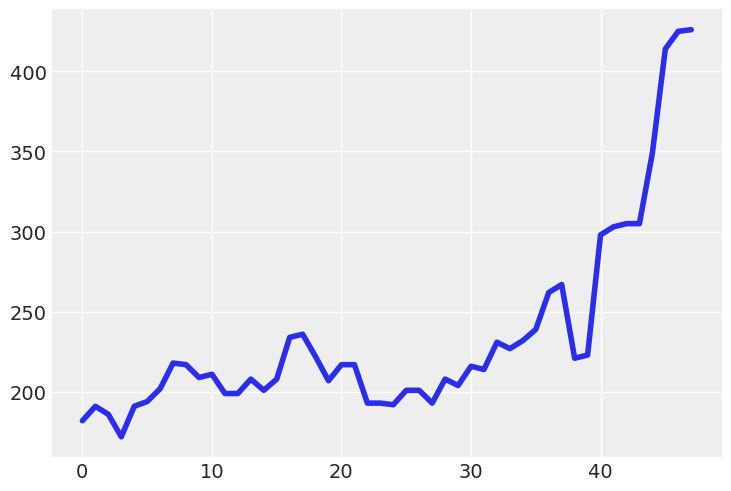

In [76]:
state_idx = pd.get_dummies(
        [i[0] for i in y]
    ).values.argmax(1)

gender_idx = pd.get_dummies(
        [i[1] for i in y]
    ).values.argmax(1)

legal_idx = pd.get_dummies(
        [i[2] for i in y]
    ).values.argmax(1)

state = np.unique(state_idx).shape[0]
gender = np.unique(gender_idx).shape[0]
legal = np.unique(legal_idx).shape[0]

n_series = y.columns.unique().shape[0]
y = y.values
X = np.arange(y.shape[0]).reshape(y.shape[0], 1)

plt.plot(X, y[:,0]);

# 1. EDA

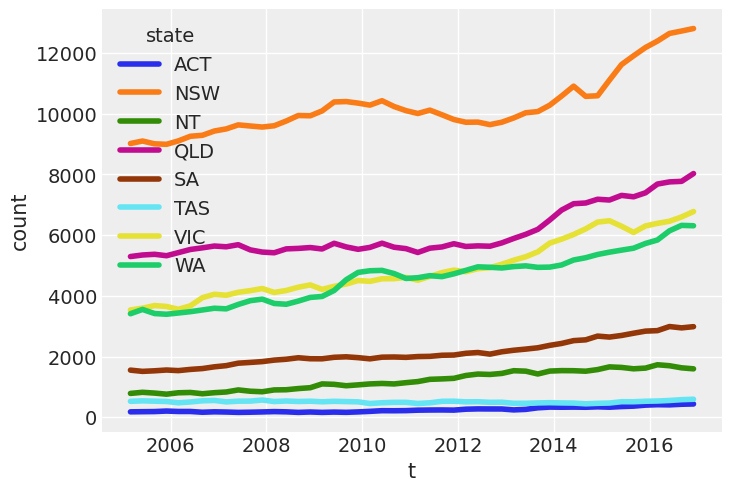

In [37]:
# Prison count by state
prison_state = prison.groupby(['t','state'])['count'].sum().reset_index()
sns.lineplot(data=prison_state, x = "t", y = "count", hue = "state");

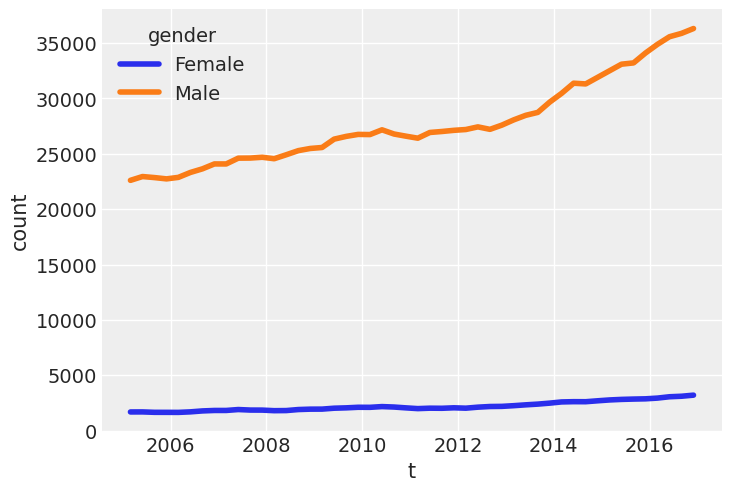

In [38]:
# Prison count by gender
prison_gender = prison.groupby(['t','gender'])['count'].sum().reset_index()
sns.lineplot(data=prison_gender, x = "t", y = "count", hue = "gender");

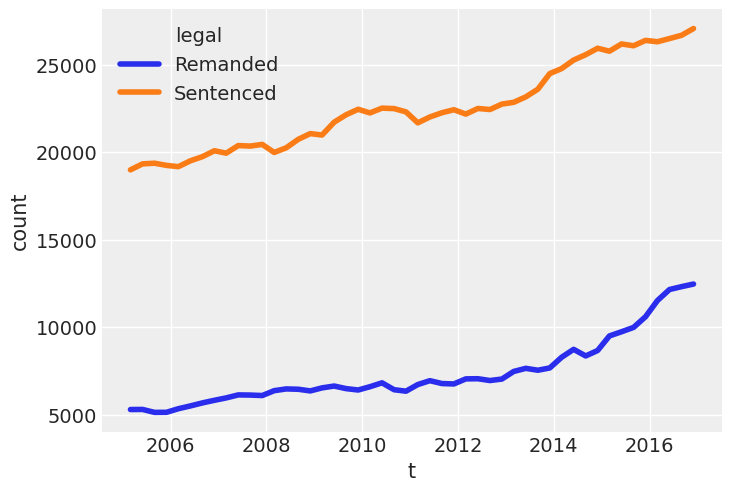

In [39]:
# Prison count by legal
prison_legal = prison.groupby(['t','legal'])['count'].sum().reset_index()
sns.lineplot(data=prison_legal, x = "t", y = "count", hue = "legal");

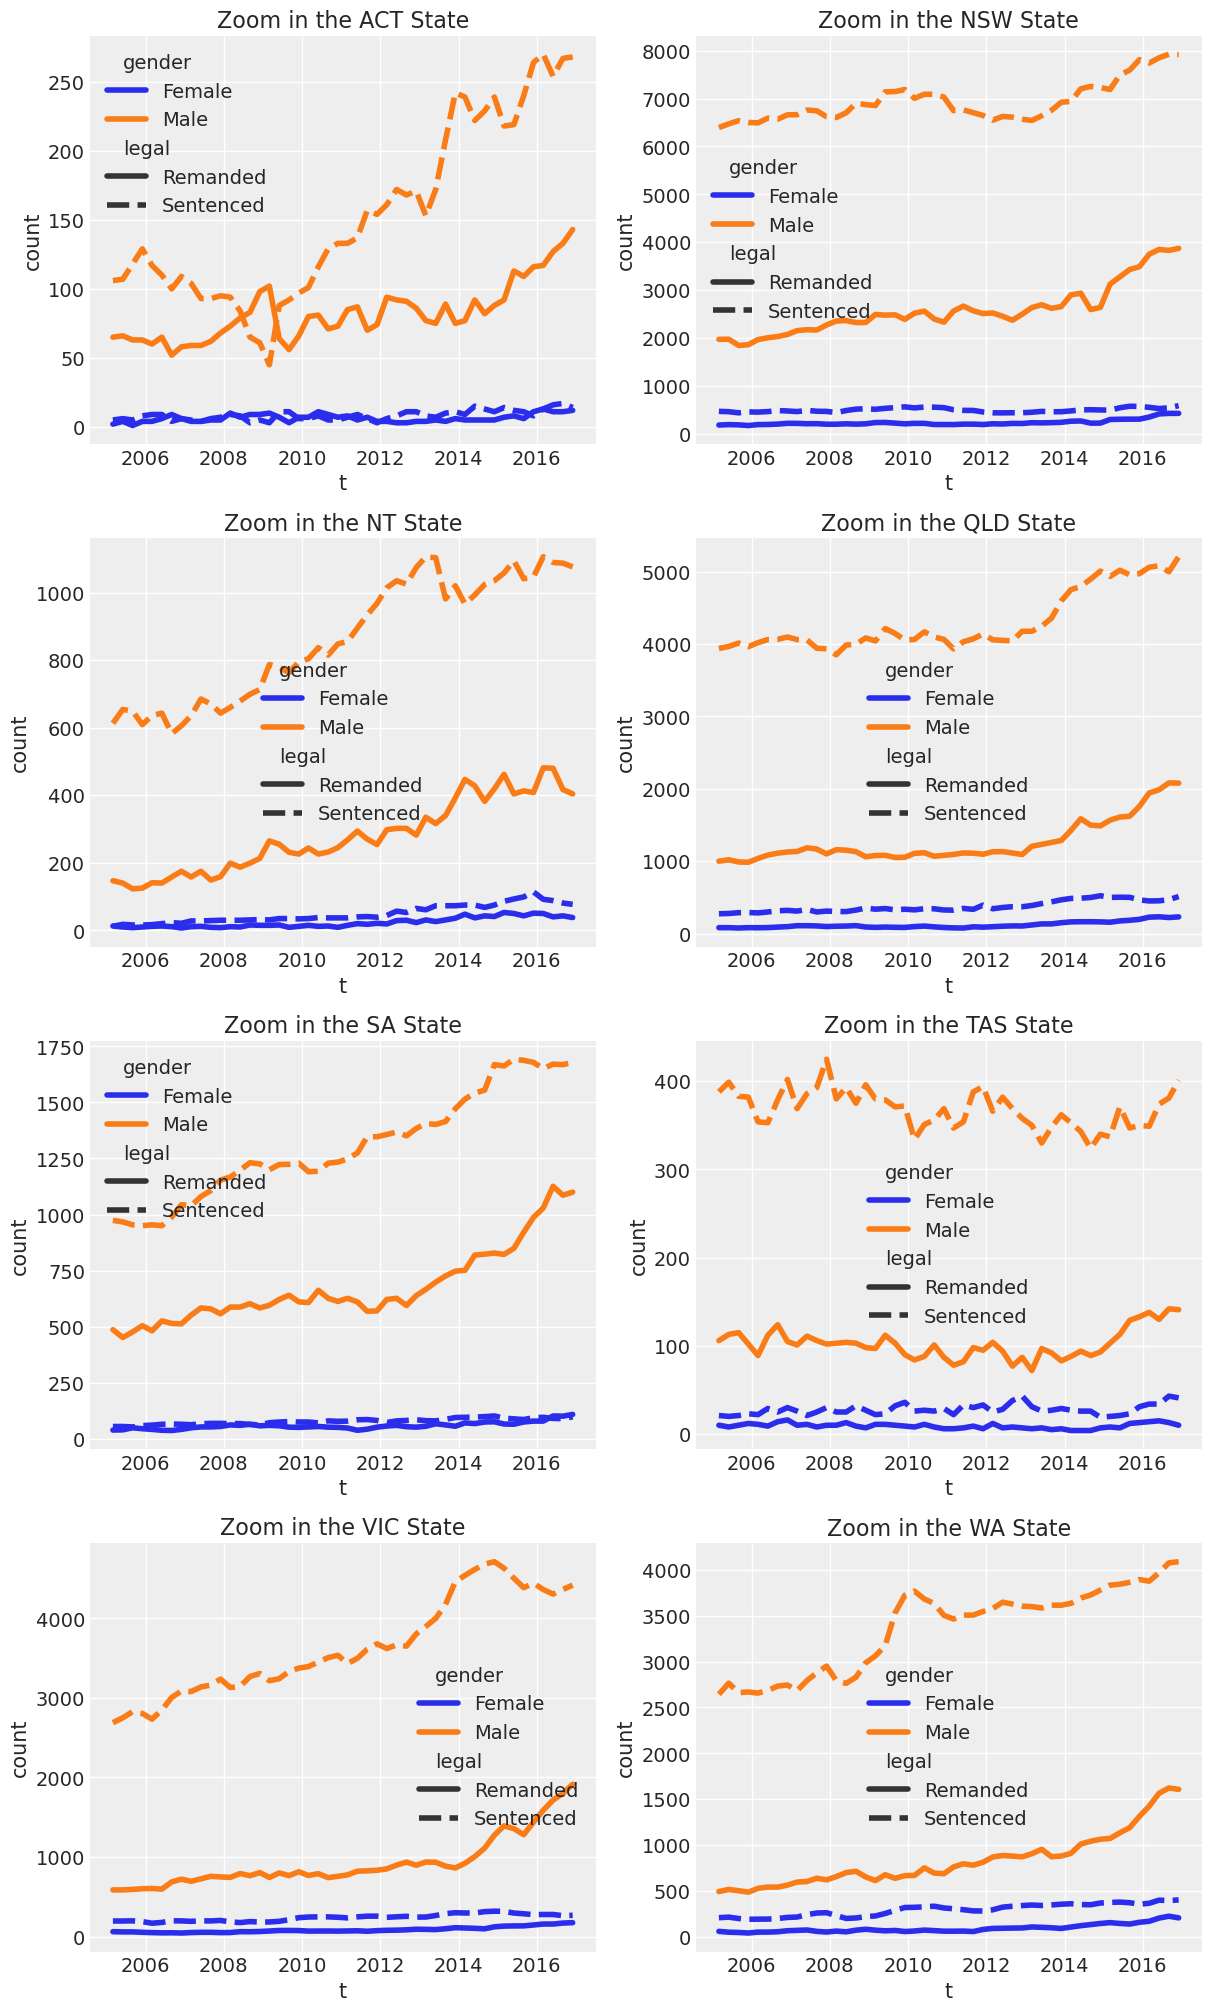

In [51]:
# Zoom in different states
_, ax = plt.subplots(4, 2, figsize=(12,20))
ax = ax.ravel()


for idx, state in enumerate(prison.state.unique()):
    sns.lineplot(data=prison.query("state == '{}'".format(state)), ax=ax[idx], x = "t", y = "count", hue = "gender", style="legal").set_title("Zoom in the {} State".format(state));

# 2. Gaussian Process Regression

## 2.1 Model Definition

### 2.1.1 Gaussian Process Regression

Let's start our definition with the simplest case, when we have $n$ observations of a univariate time series $y$, each associated with a scalar time point $x$.

The generative model for a Gaussian process regression can then be defined as:

$$\begin{aligned}
\theta &\sim g(\phi) \\
f(x) &\sim \text{GP}(\mu(x), k_{\theta}(x)) \\
y_i &\sim \mathcal{N}(f(x_i, \sigma)
\end{aligned}$$

where \mu(x) is the mean of $f(x)$ and $k_{\theta}(x)$ is the kernel ($\theta$ are its parameters), which defines the covariance between any two evaluations of $f(x)$:

$$cov(f(x_i), f(x_j)) = k(x_i, x_j | \theta)$$

This results in a $n \times n$ covariance matrix, where each entry is defined by $K[i,j]=k(x_i,x_j|\theta)$.

A GP is a stochastic process, indexed by $x \in R$. Any finite sample realized from this stochastic process is a jointly multivariate normal. 

The finite dimensional generative model for the GP is:

$$\begin{aligned}
\theta &\sim g(\phi) \\
f &\sim \text{MvNormal}(0, k_{\theta}(x)) \\
y_i &\sim \mathcal{N}(f(x_i), \sigma)
\end{aligned}$$


### 2.1.2 Cox Process
A Cox process is closely related to a Poisson process. A discrete random variable $X$ is Poisson distributed if the number of events or counts $k$, has the following form:

$$\begin{equation}
Poiss(k; \lambda) = Pr\{X=k\} = \frac{\lambda^{k}}{k!}\exp(-\lambda)
\end{equation}$$

Note that the mean of the Poisson RV is equal to its rate as well as its variance: $E[X] = VAR[X] = \lambda$. In addition, the rates are additive. If $X_i$ are iid Poisson random variables with rate $\lambda_i$, then

$$\begin{equation}
    S = \sum_{i=i}^{n} X_i \sim Poiss\bigg(\sum_{i=1}^{n} \lambda_i \bigg)
\end{equation}$$

A Poisson process is defined as random countable subset of a space $S$ such that for any disjoint subsets $A_1,...,A_n$ of $S$, the number of points in each subset $N(A_1),...,N(A_n)$ are independent random variables that are Poisson distributed: $N(A_k) \sim Poiss(\mu(A_k))$, where the rate is defined by a mean measure $\mu(A)$ often expressed in terms of the rate function $\lambda(x): S \rightarrow \mathbb{R}^{+}$:

$$\begin{equation}
    \mu(A) = \int_A \lambda(x) dx < \infty
\end{equation}$$

If the rate function $\lambda(x)$ is constant, we have a *homogeneous* Poisson process, where $\mu(A) = \lambda |A|$, and $|A|$ denotes the measure of $A$, e.g. area in $\mathbb{R}^{2}$. If the rate function is spatially varying, then we have an *inhomogeneous* Poisson process.

A Cox Process is a Poisson process in which the rate function is itself a stochastic process. In particular, a Log Gaussian Cox Process (LGCP) models the rate function $\lambda(x)$ as a transformation of a Gaussian Process (GP) that guarantees positivity. Common transformations include exponential, sigmoid and square functions. We can summarize the Cox Process as follows:

$$\begin{eqnarray}
    f(x) &\sim& GP\big(m(x), K(x,x^{\prime})\big) \\
    \lambda(x) &=& \exp\{f(x)\} \\
    y(A) &\sim& Poiss\bigg(\int_A \lambda(x) dx \bigg)
\end{eqnarray}$$


### 2.1.3 GP with Poisson outcomes

In our case we are dealing with count data. Nevertheless, we want to use one or more GPs as latent processes for the Poisson mean (and standard deviation, as they are the same).

$$\begin{aligned}
\theta &\sim g(\phi) \\
f &\sim MvNormal(0, K_{theta}(x)) \\
y_i &\sim Poisson(\exp(f_i)) \forall i \in {1,...,n} 
\end{aligned}$$

We are using the conventional log-link function to ensure that the $\exp(f_i)$ is always positive.


### 2.1.4 GP Kernels

Our model is a sum of three GPs for the signal and one GP for the noise:

1. A long term smoothing rising trend represented by an exponentiated quadratic kernel
2. A periodic term.
3. Small and medium term irregularities with a rational quadratic kernel
4. The noise is modeled as the sum of an Exponential and a white noise kernel

The prior on $y$ as a function of time is,

$$f(t) \sim GP_{slow}(0, k_1(x, x')) + GP_{med}(0, k_2(x, x')) + GP_{per}(0, k_3(x, x')) + GP_{noise}(0, k_4(x,x'))$$

### 2.1.5 Hierarchical Cox Process with fixed and random effects, using a multi-output GP prior and allowing different inputs size

In our data we have cross-sectional correlations between our series. Another example of an important aspect to the data are the time-invariant gender-level, state-level and legal-level differences in mean. 

We also see time trends within state, gender and level but, for instance, when zooming in states we see for trends are clearly different whithin legal of gender (e.g. the male behaviour on TAS and SA). 

All of the above points suggest a model structure that accounts for time-varying and time-invariant state, gender and legal factors. Our data represents number of people (i.e. counts), which means that we will use a Poisson likelihood.

$$\begin{aligned}
y_{t,s} &\sim Poisson(\exp(\mu_{t,s})) \\
\mu_{t,s} &= a + a^{state}_i + a^{gender}_j + a^{legal}_k + f_{t,i,j,k} \\
f_{t,i,j,k} &\sim \text{MvNormal}(0, k_{slow}(x, x') + k_{med}(x, x') + k_{per}(x, x') + k_{noise}(x,x'))
\end{aligned}$$


Note: we have to define strong priors over all the parameters to make the model indentifiable. To do that we can define priors with shrinkage properties (i.e. adaptative priors) on the intercepts. An example could be,

$$a^{state}_{i} \sim \mathcal{N}(0, \sigma^{state})$$



### 2.1.5 Group structure

$$
\begin{align*}
y_t &= a + a_{cov1}X1 + a_{cov2}X2 + a_{cov3}X3 + b \;t + \gamma_t + \epsilon_t,  & \epsilon_t \sim NID(0, \sigma^2_\epsilon) \\
\epsilon_{t+1} &= \phi \epsilon_t + \eta_t, & \eta_t \sim NID(0, \sigma^2_\eta) \\
\gamma_{1,t+1} &= -\gamma_{1,t} - \gamma_{2,t} - ... - \gamma_{12,t} \\
\gamma_{2,t+1} &= \gamma_{1,t} \\
\gamma_{3,t+1} &= \gamma_{2,t} \\
[...]
\end{align*}
$$

where $a$ represents the deterministic level, $b$ the deterministic trend, $t$ denotes time, $\epsilon$ refer to the observation disturbance, $\gamma$ to the deterministic seasonal component of the series, $a_{cov}$ are the group effects, $\phi$ is the autoregressive coefficient and $\eta$ are the residuals.

The first equation is called the observation or measurement equation.


### 2.1.6 Model structure

1. Hyperprior level 0: All
2. Hyperprior level 1: state, gender, legal
3. Adaptative priors
4. Latent process
5. Likelihood

### 2.1.7 Modeling groups


state -> s, gender -> g, legal -> l

$$\begin{aligned}
Y_{t,i} = \beta_0&  & \textrm{baseline} \\ 
&+\sum_s{\beta_{1,s} x_{1,s}} + \sum_g{\beta_{2,g} x_{2,g}} + \sum_l{\beta_{3,l} x_{3,l}} & \textrm{group effects}\\ &+\beta_{4} * Y_{t-1} & \textrm{AR effect - covariate} \\
&+ \epsilon & \textrm{error term} \end{aligned}$$


#### 2.1.7.1 Define constraints to the deflections (effects):

We want the predicted value to be a baseline plus a deflection due to the level of factor 1 plus a deflection due to the level of factor 2, etc.

$$\sum_s\beta_{1,s} = 0$$
$$\sum_g\beta_{2,g} = 0$$
$$\sum_l\beta_{3,l} = 0$$

So,

$$\begin{aligned}
&\beta_0 +\sum_s{\beta_{1,s} x_{1,s}} + \sum_g{\beta_{2,g} x_{2,g}} + \sum_l{\beta_{3,l} x_{3,l}} +\beta_{4} * x_{cov} \\
&= \alpha_0 + \bar \alpha - \alpha_{cov} \bar x_{cov} + \sum_s{(\alpha_s - \bar \alpha)x_s} + \sum_g{(\alpha_g - \bar \alpha)x_g} + \sum_l{(\alpha_l - \bar \alpha)x_l} + \alpha_{cov} x_{cov}
\end{aligned}$$

where $\bar \alpha = \frac{1}{S} \sum^{S}_{s=1} \alpha_s + \frac{1}{G} \sum^{G}_{g=1} \alpha_g + \frac{1}{L} \sum^{L}_{l=1}\alpha_{l}$

In our case $x_{cov} = y_{t-1}$, since we are defining an autoregressive process.

Describe the method that uses the cell structure to derive the coefficients (overall mean, marginal means, etc).
$$\begin{aligned}
\beta_0 &= \alpha_0 +  \bar \alpha - \alpha_{cov} \bar x_{cov} \\
\beta_1 &= \frac{1}{S} \sum_s (\alpha_s - \bar \alpha) \\
\beta_2 &= \frac{1}{G} \sum_g (\alpha_g - \bar \alpha) \\
\beta_3 &= \frac{1}{L} \sum_l (\alpha_l - \bar \alpha) \\
\beta_{cov} &= \alpha_{cov}
\end{aligned}$$

Do the same for interactions.



# 3. Single series prediction using Gaussian Processes

## 3.1 Hyperpriors selection for GPs

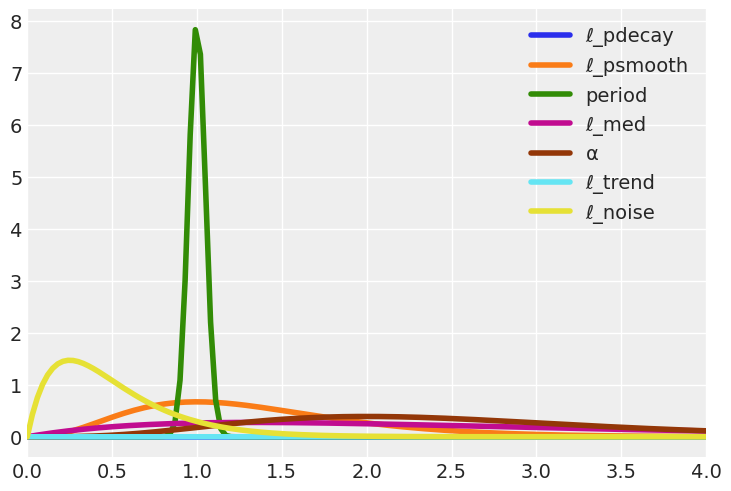

In [66]:
x = np.linspace(0, 150, 5000)
priors = [
    ("ℓ_pdecay",  pm.Gamma.dist(alpha=10, beta=0.075)),
    ("ℓ_psmooth", pm.Gamma.dist(alpha=4,  beta=3)),
    ("period",    pm.Normal.dist(mu=1.0,  sigma=0.05)),
    ("ℓ_med",     pm.Gamma.dist(alpha=2,  beta=0.75)),
    ("α",         pm.Gamma.dist(alpha=5,  beta=2)),
    ("ℓ_trend",   pm.Gamma.dist(alpha=4,  beta=0.1)),
    ("ℓ_noise",   pm.Gamma.dist(alpha=2,  beta=4))]

#p = figure(title='Lengthscale and period priors',
#           plot_width=550, plot_height=350,  x_range=(-1, 8), y_range=(0, 2))
#p.yaxis.axis_label = 'Probability'
#p.xaxis.axis_label = 'Years'

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])
    
plt.xlim(0,4)
plt.legend();

* ℓ_pdecay: The periodic decay. The smaller this parameter is, the faster the priodicity goes away.
* ℓ_psmooth: The smoothness of the periodic component. It controls how the "sinusoidal" the periodicity is.
* period: We put a very strong prior on $p$, the period that is centered at 4, since the data is quarterly
* ℓ_med: This is the lengthscale for the short to medium long variations. This prior has most of its mass below 6 quarters.
* $\alpha$: This is the shape parameter. This prior is centered at 3, since we're expecting there to be some more variation than could be explained by an exponentiated quadratic
* ℓ_trend: The lengthscale of the long term trend. It has a wide prior with mass on a 3 year scale.
* ℓ_noise: The lengthscale of the noise covariance. This noise should be very rapid, in the scale of several months to at most a year or two.

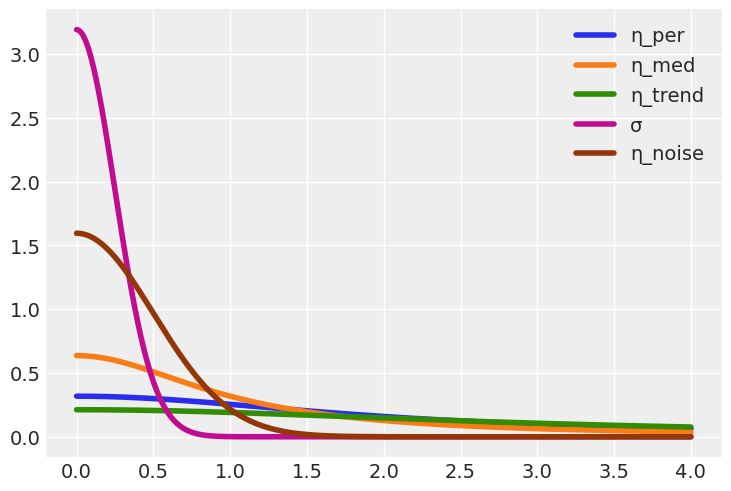

In [69]:
x = np.linspace(0, 4, 5000)
priors = [
    ("η_per",   pm.HalfCauchy.dist(beta=2)),
    ("η_med",   pm.HalfCauchy.dist(beta=1.0)),
    ("η_trend", pm.HalfCauchy.dist(beta=3)),
    ("σ",       pm.HalfNormal.dist(sigma=0.25)),
    ("η_noise", pm.HalfNormal.dist(sigma=0.5))]

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])
    
plt.legend();

For all the scale priors we use distributions that shrink the scale towards zero. The seasonal component and the long term trend have the least mass near zero, since they are the largest influences in the data.

* $\eta$_per: Scale of the periodic or seasonal component
* $\eta$_med: Scale of the short to medium term component
* $\eta$_trend: Scale of the long term trend
* $\sigma$: Scale of the white noise 
* $\eta$_noise: Scale of the correlated, short term noise

## 3.2 Model

In [430]:
with pm.Model() as model:
    
    # quarterly periodic component
    η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
    period  = pm.Normal("period", mu=4, sigma=0.05)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=4, beta=3)
    cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth)
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)
    
    # small/medium term irregularities
    η_med = pm.HalfCauchy("η_med", beta=0.5, testval=0.1)
    ℓ_med = pm.Gamma("ℓ_med", alpha=2, beta=0.75)
    α = pm.Gamma("α", alpha=5, beta=2)
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)
    
    # long term trend
    η_trend = pm.HalfCauchy("η_trend", beta=2, testval=2.0)
    ℓ_trend = pm.Gamma("ℓ_trend", alpha=4, beta=0.1)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)
    
    # noise model
    η_noise = pm.HalfNormal("η_noise", sigma=0.5, testval=0.05)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=4)
    σ  = pm.HalfNormal("σ",  sigma=0.25, testval=0.05)
    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) +\
                pm.gp.cov.WhiteNoise(σ)
    
    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_medium + gp_trend
    
    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=X, y=y[:,0], noise=cov_noise)
    
    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

In [431]:
# display the results, dont show transformed parameter values
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['period:3.999986502353153',
 'α:1.0138656156093386',
 'η_med:20.216652047896186',
 'η_noise:0.0005967783711695394',
 'η_per:2.651283673674133e-07',
 'η_trend:272.09953003957503',
 'σ:6.153863117317088e-07',
 'ℓ_med:2.0487413394915515',
 'ℓ_noise:0.2499169578544611',
 'ℓ_psmooth :1.0001055356531163',
 'ℓ_trend:22.153643248666636']

In [432]:
# new values from x=0 to x=60
X_new = np.linspace(0, 60, 600)[:,None]

# Add the GP conditional to the model, given the new X values
with model:
    f_pred_1 = gp.conditional('f_pred_1', X_new)

In [433]:
# To use the MAP values replace the trace with a length-1 list with mp
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred_1], samples=500)

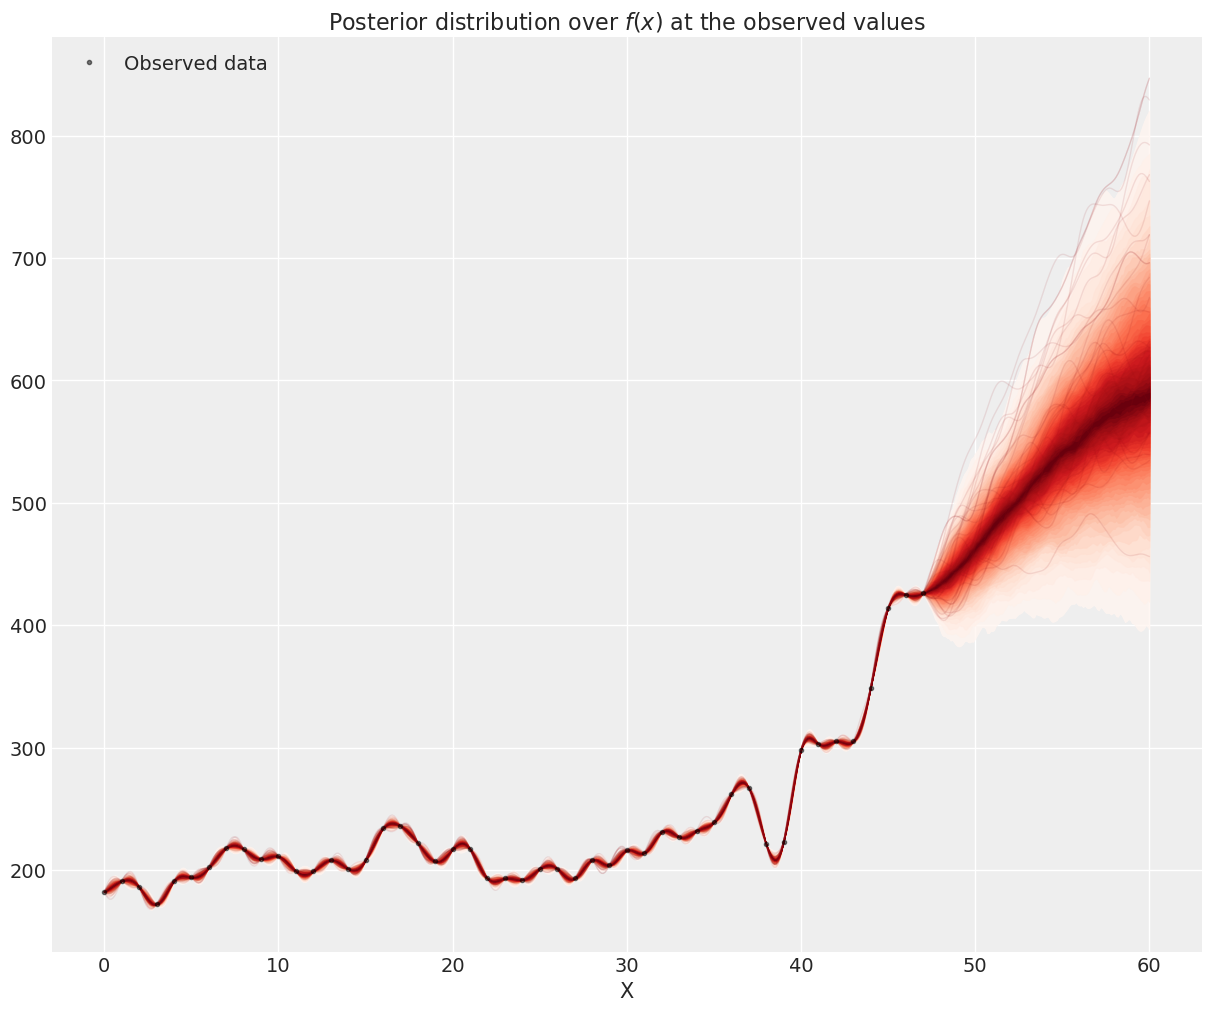

In [434]:
# plot the results
fig = plt.figure(figsize=(12,10)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred_1"], X_new);

# plot the data
plt.plot(X, y[:,0], 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

# 4. Hierarchical Cox Process with fixed and random effects, using a multi-output GP prior and allowing different inputs size



## 4.1 Cov functions

##### See ./support_notebooks/'Vector Output GP.ipynb' for more information on how to generate these cov functions

We want to generate a covariance matrix that allows representation of all possible combinations between all time points of all series.

In [9]:
n=y.shape[0]
s=y.shape[1]
h = np.zeros((n*s,))
for s_ in range(s): 
    for n_ in range(n):
        h[(n)*s_+n_] = s_

h = h[:,None]
t = np.arange(n*s)[:,None]
X = np.hstack((t, h))

##### High local correlation

In [11]:
ls = [20, 10000]
eta=1
cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)
K = cov(X).eval()

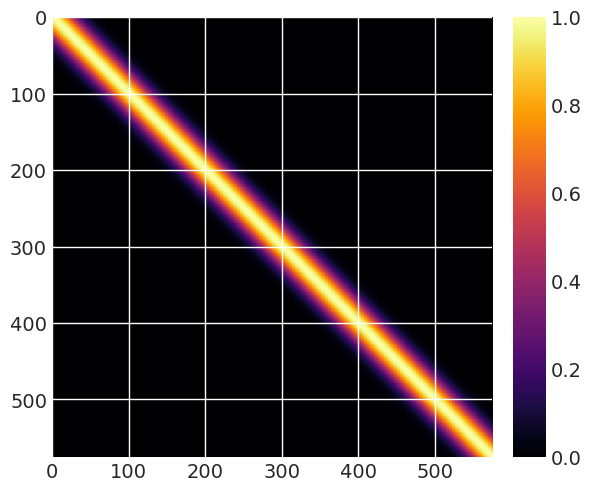

In [12]:
m = plt.imshow(K, cmap="inferno", interpolation='none')
plt.colorbar(m);

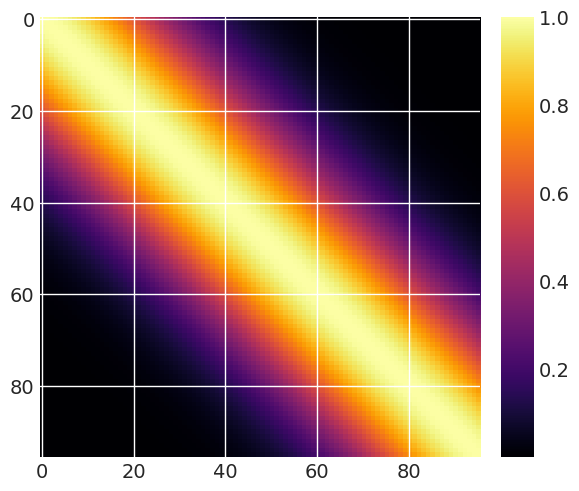

In [13]:
# Zoom in cov of time series 1 and 2
m = plt.imshow(K[:n*2,:n*2], cmap="inferno", interpolation='none')
plt.colorbar(m);

In [14]:
# Three samples using the covariance matrix above
samples = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T

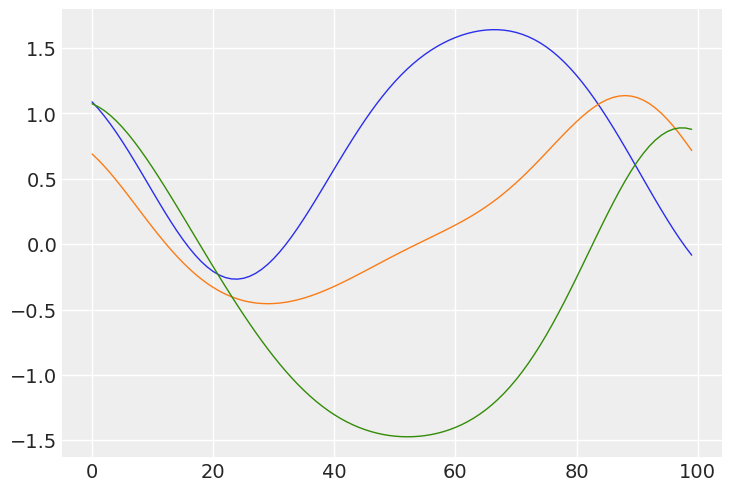

In [15]:
plt.plot(samples[:100], linewidth=1);

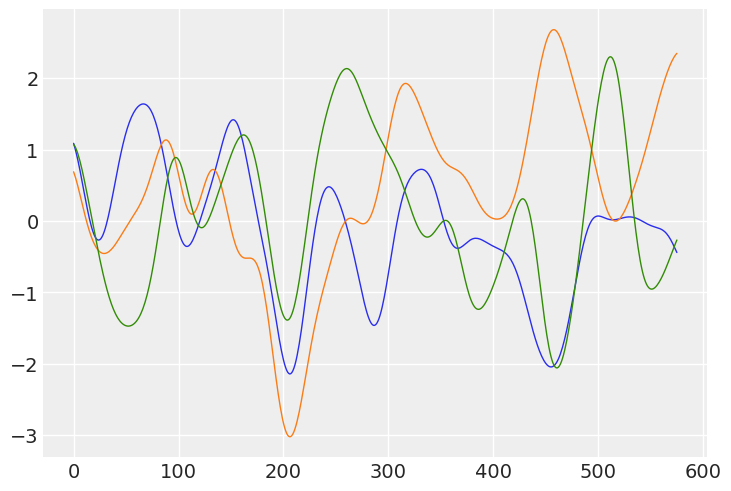

In [16]:
plt.plot(samples, linewidth=1);

We can see how very high local correlations impact a multivariate normal sampling, the realization of the Gaussian process.

Closer series are highly correlated while in the long term the correlation is low.

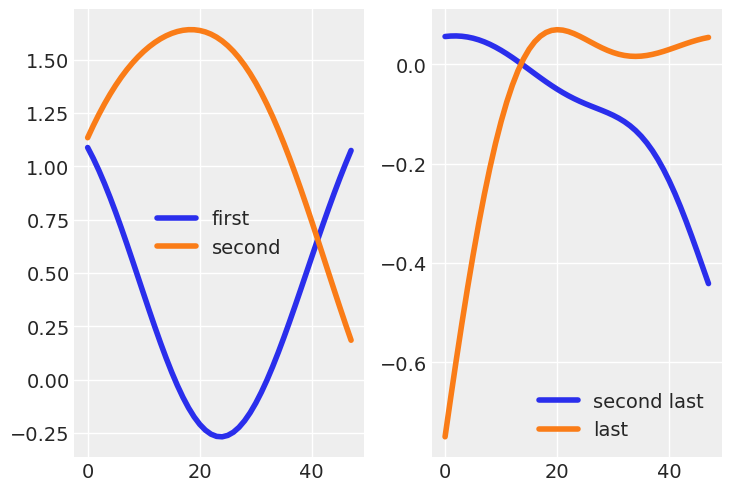

In [17]:
# Comparing first two and last two series from the same sampling
_, ax = plt.subplots(1, 2)
ax = ax.ravel()

ax[0].plot(samples[:n,0], label='first')
ax[0].plot(samples[n:n*2,0], label='second')
ax[0].legend()

ax[1].plot(samples[n*(s-1):,0], label='second last')
ax[1].plot(samples[n*(s-2):n*(s-1),0], label='last')
ax[1].legend();

##### High correlation between all time points of all time series (more evenly distributed)

In [12]:
l_t = [22, 5]
l_p = [1,5]
l_med = [2,5]

η_trend = 20
η_per = 2.6
η_med = 20
cov = η_trend**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l_t) + η_per**2 * pm.gp.cov.Periodic(2, period=4, ls=l_p) + η_med**2 * pm.gp.cov.RatQuad(2, ls=l_med, alpha=1)
K = cov(X).eval()

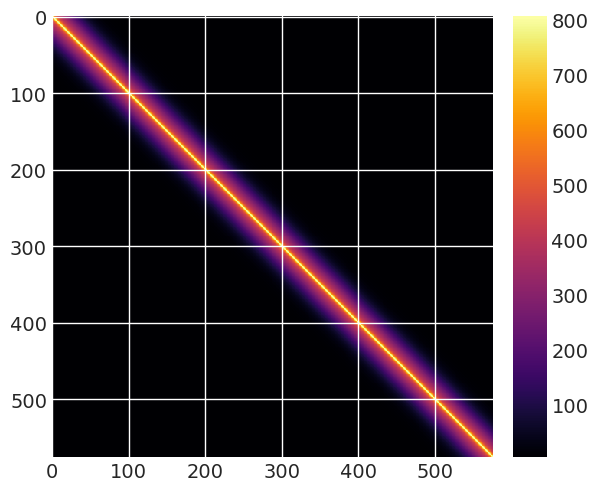

In [13]:
m = plt.imshow(K, cmap="inferno", interpolation='none')
plt.colorbar(m);

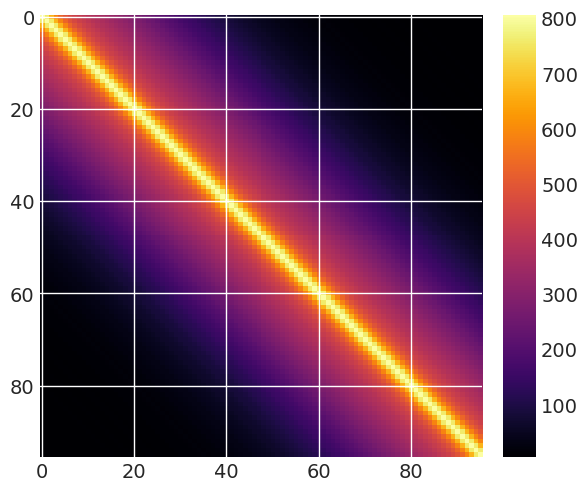

In [14]:
# Zoom in cov of time series 1 and 2
m = plt.imshow(K[:n*2,:n*2], cmap="inferno", interpolation='none')
plt.colorbar(m);

In [15]:
# Three samples using the covariance matrix above
samples = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T

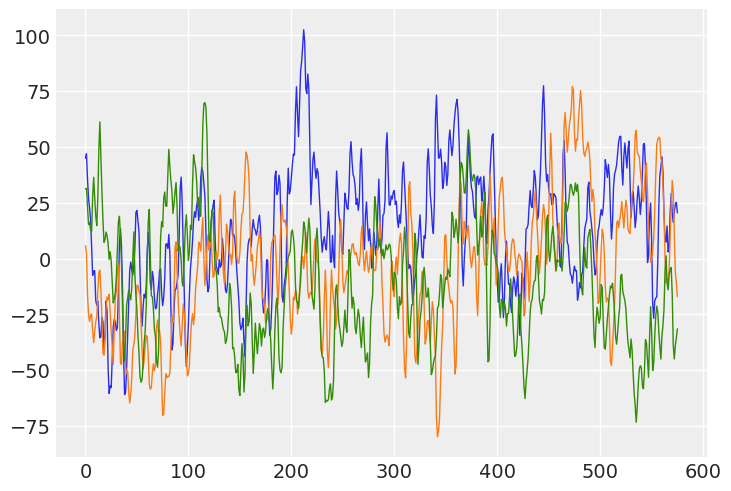

In [16]:
plt.plot(samples, linewidth=1);

This combination of kernels allows a very wide range of behaviours.

## 4.2 Cox Process with multi-output GP prior for two series

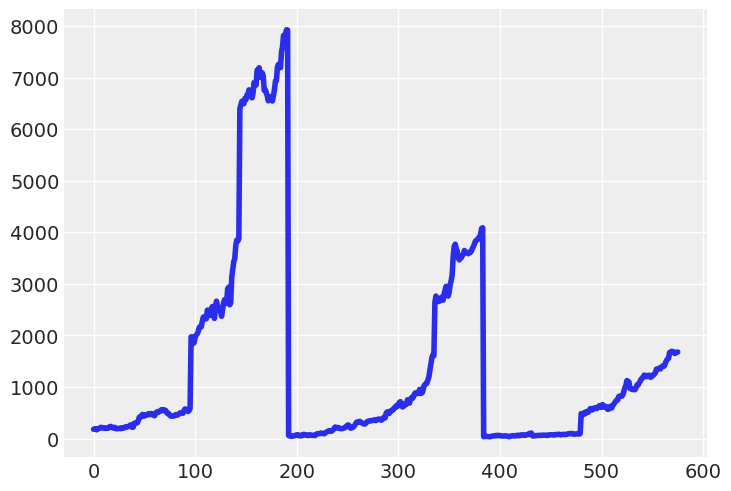

In [344]:
plt.plot(y.flatten('F'));

In [9]:
y_ = y[:,0:2]

n=y_.shape[0]
s=y_.shape[1]
h = np.zeros((n*s,))
for s_ in range(s): 
    for n_ in range(n):
        h[(n)*s_+n_] = s_

h = h[:,None]
t = np.arange(n*s)[:,None]
X = np.hstack((t, h))

y_ = y_.flatten('F')

##### Marginal regression of a GP to the parameter estimates

Let's use `find_MAP` on the marginalized GP to recover faster the parameters that we will define later.

In [10]:
y_ = y

n=y_.shape[0]
s=y_.shape[1]
h = np.zeros((n*s,))
for s_ in range(s): 
    for n_ in range(n):
        h[(n)*s_+n_] = s_

h = h[:,None]
t = np.arange(n*s)[:,None]
X = np.hstack((t, h))

y_log = np.log(y_).flatten('F')

In [11]:
with pm.Model() as model_cox_gp:
    
    # Hyper-parameter priors
    l_t = pm.Gamma('l_t', alpha=5, beta=1, shape=2)
    l_p = pm.Gamma('l_p', alpha=5, beta=1, shape=2)
    l_med = pm.Gamma('l_med', alpha=5, beta=1, shape=2)

    η_trend = pm.HalfCauchy('η_trend', beta=0.5)
    η_per = pm.HalfCauchy('η_per', beta=0.5)
    η_med = pm.HalfCauchy('η_med', beta=0.5)
    period = pm.HalfNormal('period', 0.5)
    
    l = pm.Gamma('l', alpha=5, beta=1, shape=2)
    η = pm.HalfCauchy('η', beta=0.5)
    # Cov func
    cov_func = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l_t)
                + η**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l)
                + η_per**2 * pm.gp.cov.Periodic(2, period=period, ls=l_p) 
                + η_med**2 * pm.gp.cov.RatQuad(2, ls=l_med, alpha=1))

    gp = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfCauchy("sigma", beta=5)
    f = gp.marginal_likelihood('f', X=X, y=y_log, noise=sigma)
    
    mp = pm.find_MAP()          

In [12]:
[{key: mp.get(key) for key in [i for i in mp if 'log' not in i]}]

[{'l_t': array([18.95734087,  0.75740344]),
  'l_p': array([9.70958737, 1.32215712]),
  'l_med': array([1.46054818, 1.91670355]),
  'η_trend': array(0.46435533),
  'η_per': array(2.73190639),
  'η_med': array(0.07918147),
  'period': array(0.36361703),
  'l': array([18.95734087,  0.75740344]),
  'η': array(0.46435533),
  'sigma': array(0.02485773)}]

##### Using reparameterization to speed up

https://arxiv.org/abs/1312.0906

https://sethrf.com/files/fast-hierarchical-GPs.pdf: section 4.7

Before diving into the model, it is important to note that we are using a non-centered parameterization of our multivarite normal. To explain what this means, we need to recall that the finite dimensional sample from a GP is ultimately a multivariate normal with a parameterized covariance matrix. This means that to add a multivariate normal density over $f$ to the log-posterior density, we need to invert the matrix of decompose it in some way. We use Cholesky decomposition and the factor $L$ is then multiplied by a vector of univariate normals $eta$, so $f$ is implicitly distributed as a multivariate normal random variable.

$$\begin{aligned}
\eta_i &\sim \mathcal{N}(0,1) \forall i \in {1,..,n} \\
f &= L\eta \\
f &\sim \text{MvNormal}(0, \Sigma)
\end{aligned}$$

This way we remove the prior dependency of the density of $f$ on its hyperparameters (kernel parameters).

##### Model

In [234]:
y_ = y[:,0:2]

n=y_.shape[0]
s=y_.shape[1]
h = np.zeros((n*s,))
for s_ in range(s): 
    for n_ in range(n):
        h[(n)*s_+n_] = s_

h = h[:,None]
t = np.arange(n*s)[:,None]
X = np.hstack((t, h))

y_ = y_.flatten('F')

In [235]:
with pm.Model() as model_cox_gp:
    
    # Hyper-parameter priors
    l_t = pm.Gamma('l_t', alpha=4, beta=1, shape=2)
    l_p = pm.Gamma('l_p', alpha=4, beta=1, shape=2)
    l_med = pm.Gamma('l_med', alpha=4, beta=1, shape=2)

    η_trend = pm.HalfNormal('η_trend', 1)
    η_per = pm.HalfNormal('η_per',1)
    η_med = pm.HalfNormal('η_med', 1)
    period = pm.HalfNormal('period', 1)
    
    
    l = pm.Gamma('l', alpha=4, beta=1, shape=2)
    η = pm.HalfNormal('η', 1)
    
    # Cov func
    cov_func = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l_t)
                + η**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l)
                + η_per**2 * pm.gp.cov.Periodic(2, period=period, ls=l_p) 
                + η_med**2 * pm.gp.cov.RatQuad(2, ls=l_med, alpha=1))

    # Latent Gaussian Process
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior('f', X=X, reparameterize=True)

    # GLM Likelihood
    obs = pm.Poisson('obs', mu=tt.exp(f), observed=y_)

In [236]:
with model_cox_gp:
    mp = pm.find_MAP()

In [26]:
[{key: np.exp(mp.get(key)) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'f'])]}]

[{'l_t': array([129.43380816,   2.76711872]),
  'l_p': array([109.12212046,  38.2553984 ]),
  'l_med': array([234.6227748 ,  19.00309803]),
  'η_trend': 8.421165597405208,
  'η_per': 4.72626229938937,
  'η_med': 1.419558846287205,
  'period': 2.1013231403210204,
  'l': array([129.43380816,   2.76711872]),
  'η': 8.421165597405208}]

In [238]:
with model_cox_gp:
    trace_cox_gp = pm.sample(draws=2000, 
                  tune=4000, 
                  init="advi+adapt_diag",
                  target_accept=0.90,
                  chains = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 1100
Interrupted at 1,099 [0%]: Average Loss = 1.4343e+07
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, η, l, period, η_med, η_per, η_trend, l_med, l_p, l_t]


Sampling 1 chain for 4_000 tune and 2_000 draw iterations (4_000 + 2_000 draws total) took 11074 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
#pm.traceplot(trace_cox_gp);

In [239]:
with model_cox_gp:
    ppc = pm.sample_posterior_predictive(trace_cox_gp, 2000)

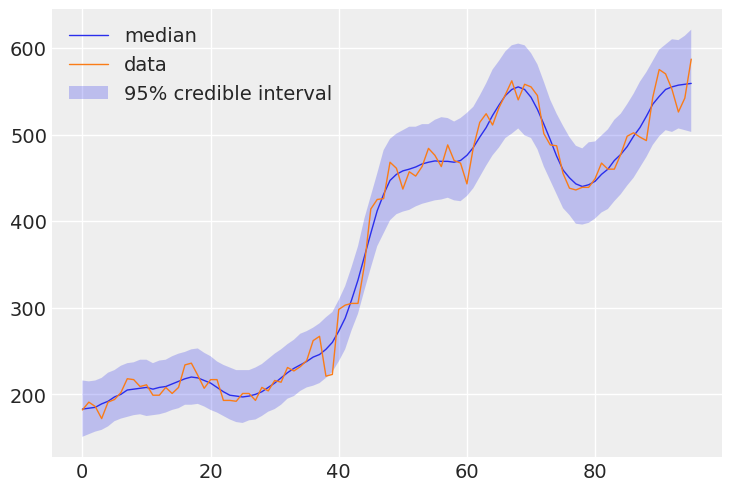

In [241]:
y_pred_q = np.percentile(ppc['obs'], axis=0, q=[2.5, 50, 97.5])
plt.plot(np.arange(n*s), y_pred_q[1], label='median', linewidth=1)
plt.fill_between(np.arange(n*s), y_pred_q[0], y_pred_q[2],
                alpha=0.25, label='95% credible interval')
plt.plot(np.arange(n*s),y_.flatten('F'), label='data', linewidth=1)
plt.legend()
plt.show()

##### Series 1

In [ ]:
n_new = n+12
h = np.zeros((n_new,1))
t = np.arange(n_new)[:,None]
X_new = np.hstack((t, h))

In [ ]:
with model_cox_gp:
    f_n = gp.conditional('f_n', Xnew=X_new)
    y_pred = pm.Poisson("y_pred", mu=tt.exp(f_n), shape=X_new.shape[0])

In [272]:
with model_cox_gp:
    pred_samples = pm.sample_posterior_predictive(trace_cox_gp, 
                                                  vars=[f_n, y_pred], 
                                                  samples=500)

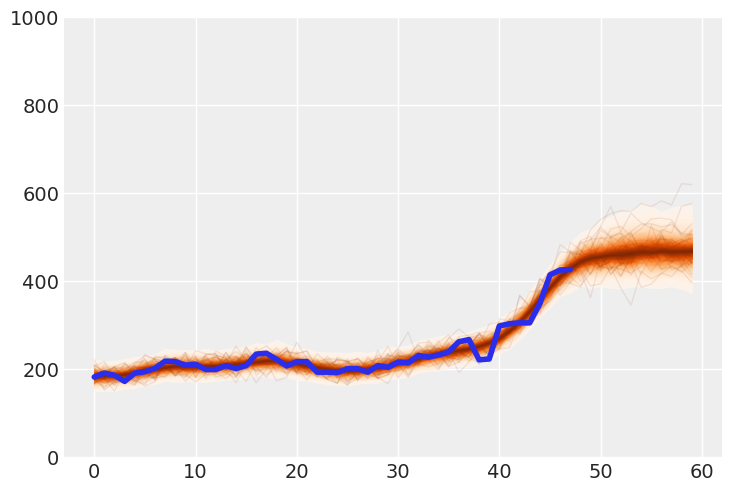

In [275]:
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, pred_samples['y_pred1'][:500,:], X_new[:,0], palette='Oranges')
plt.plot(y[:,0])
plt.ylim(0, 1000);

##### Series 2

In [289]:
n_new = n+12
h = np.ones((n_new,1))
t = np.arange(n, n + n_new)[:,None]
X_new = np.hstack((t, h))

In [290]:
with model_cox_gp:
    f_n_s_1 = gp.conditional('f_n_s_1', Xnew=X_new)
    y_pred_s_1 = pm.Poisson("y_pred_s_1", mu=tt.exp(f_n_s_1), shape=X_new.shape[0])

In [291]:
with model_cox_gp:
    pred_samples = pm.sample_posterior_predictive(trace_cox_gp, 
                                                  vars=[f_n_s_1, y_pred_s_1], 
                                                  samples=500)

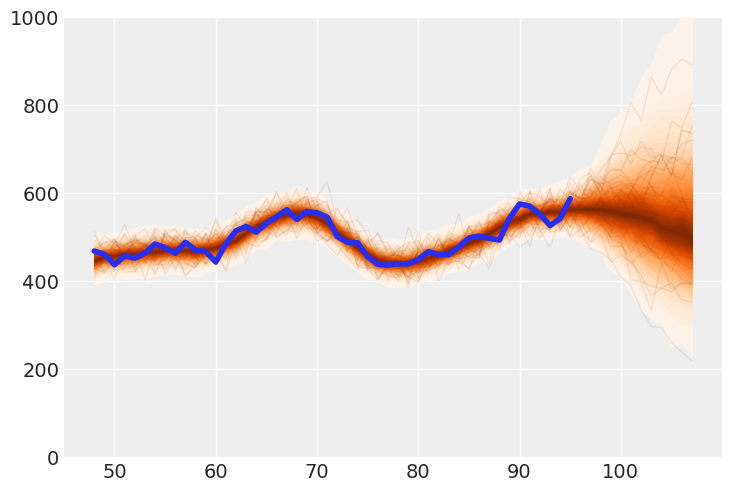

In [297]:
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, pred_samples['y_pred_s_1'][:500,:], X_new[:,0], palette='Oranges')
plt.plot(np.arange(n,n*2),y[:,1])
plt.ylim(0, 1000);

## 4.3 Adding more series to the Cox Process with multi-output GP prior and testing different performance strategies

##### Using MAP to get parameters for the GP prior and use those values to run the model

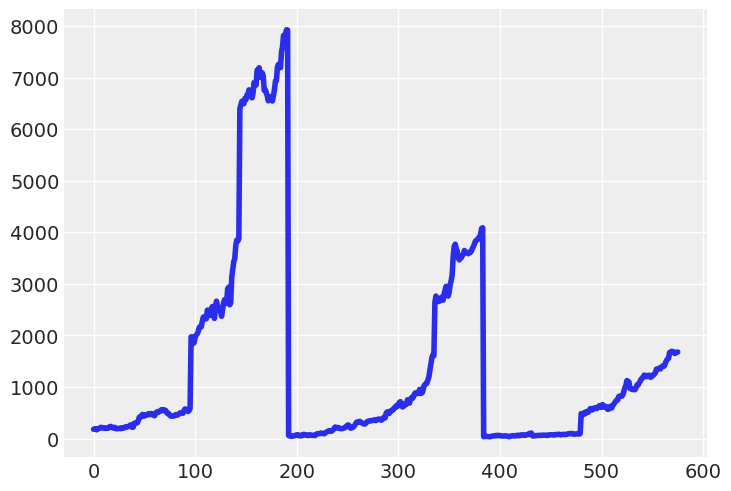

In [14]:
y_ = y

n=y_.shape[0]
s=y_.shape[1]
h = np.zeros((n*s,))
for s_ in range(s): 
    for n_ in range(n):
        h[(n)*s_+n_] = s_

h = h[:,None]
t = np.arange(n*s)[:,None]
X = np.hstack((t, h))

y_ = y_.flatten('F')
plt.plot(y_);

In [15]:
with pm.Model() as model_cox_gp:
    
    # Hyper-parameter priors
    l_t = pm.Gamma('l_t', alpha=4, beta=1, shape=2)
    l_p = pm.Gamma('l_p', alpha=4, beta=1, shape=2)
    l_med = pm.Gamma('l_med', alpha=4, beta=1, shape=2)

    η_trend = pm.HalfNormal('η_trend', 1)
    η_per = pm.HalfNormal('η_per',1)
    η_med = pm.HalfNormal('η_med', 1)
    period = pm.HalfNormal('period', 1)
    
    
    l = pm.Gamma('l', alpha=4, beta=1, shape=2)
    η = pm.HalfNormal('η', 1)
    
    # Cov func
    cov_func = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l_t)
                + η**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l)
                + η_per**2 * pm.gp.cov.Periodic(2, period=period, ls=l_p) 
                + η_med**2 * pm.gp.cov.RatQuad(2, ls=l_med, alpha=1))

    # Latent Gaussian Process
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior('f', X=X, reparameterize=True)

    # GLM Likelihood
    obs = pm.Poisson('obs', mu=tt.exp(f), observed=y_)

In [16]:
with model_cox_gp:
    mp = pm.find_MAP()

In [25]:
[{key: np.exp(mp.get(key)) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'f'])]}]

[{'l_t': array([129.43380816,   2.76711872]),
  'l_p': array([109.12212046,  38.2553984 ]),
  'l_med': array([234.6227748 ,  19.00309803]),
  'η_trend': 8.421165597405208,
  'η_per': 4.72626229938937,
  'η_med': 1.419558846287205,
  'period': 2.1013231403210204,
  'l': array([129.43380816,   2.76711872]),
  'η': 8.421165597405208}]

In [17]:
mp_list = [{key: mp.get(key) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'f'])]}]

In [18]:
with pm.Model() as model_cox_gp:
    
    # Hyper-parameter priors
    l_t = mp_list[0]['l_t']
    l_p = mp_list[0]['l_p']
    l_med = mp_list[0]['l_med']

    η_trend = mp_list[0]['η_trend']
    η_per = mp_list[0]['η_per']
    η_med = mp_list[0]['η_med']
    period = mp_list[0]['period']
    
    
    l = mp_list[0]['l']
    η = mp_list[0]['η']
    
    # Cov func
    cov_func = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l_t)
                + η**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l)
                + η_per**2 * pm.gp.cov.Periodic(2, period=period, ls=l_p) 
                + η_med**2 * pm.gp.cov.RatQuad(2, ls=l_med, alpha=1))

    # Latent Gaussian Process
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior('f', X=X, reparameterize=True)

    # GLM Likelihood
    obs = pm.Poisson('obs', mu=tt.exp(f), observed=y_)

In [19]:
with model_cox_gp:
    trace_cox_gp = pm.sample(draws=2000, 
                  tune=4000, 
                  init="advi+adapt_diag",
                  target_accept=0.90,
                  chains=1,
                  cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 101200
Interrupted at 101,199 [50%]: Average Loss = 3.5777e+05
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_]


Sampling 1 chain for 4_000 tune and 2_000 draw iterations (4_000 + 2_000 draws total) took 976 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [20]:
with model_cox_gp:
    ppc = pm.sample_posterior_predictive(trace_cox_gp, 2000)

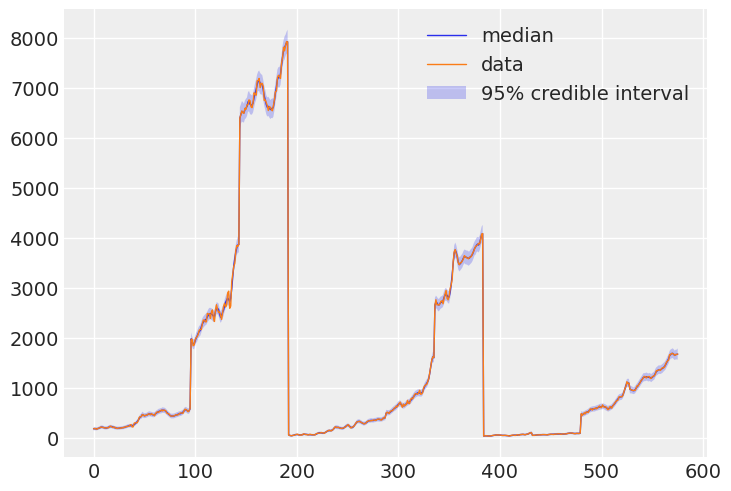

In [21]:
y_pred_q = np.percentile(ppc['obs'], axis=0, q=[2.5, 50, 97.5])
plt.plot(np.arange(n*s), y_pred_q[1], label='median', linewidth=1)
plt.fill_between(np.arange(n*s), y_pred_q[0], y_pred_q[2],
                alpha=0.25, label='95% credible interval')
plt.plot(np.arange(n*s),y_.flatten('F'), label='data', linewidth=1)
plt.legend()
plt.show()

##### Series 1

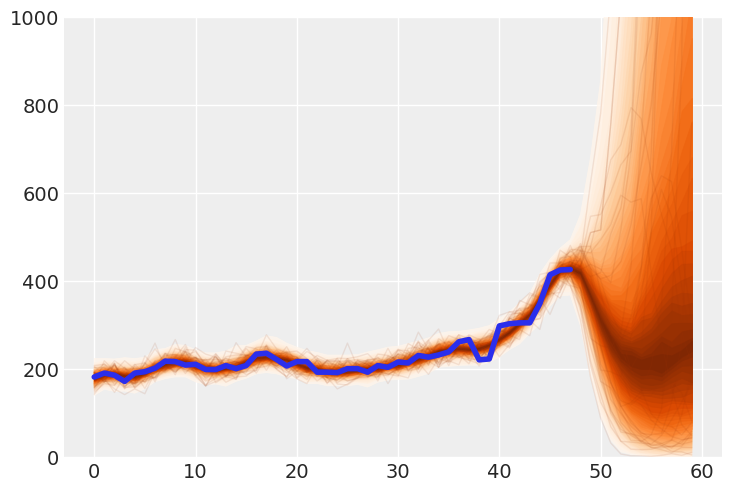

In [22]:
n_new = n+12
h = np.zeros((n_new,1))
t = np.arange(n_new)[:,None]
X_new = np.hstack((t, h))

with model_cox_gp:
    f_n = gp.conditional('f_n', Xnew=X_new)
    y_pred = pm.Poisson("y_pred", mu=tt.exp(f_n), shape=X_new.shape[0])

with model_cox_gp:
    pred_samples = pm.sample_posterior_predictive(trace_cox_gp, 
                                                  vars=[f_n, y_pred], 
                                                  samples=500)

ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, pred_samples['y_pred'][:500,:], X_new[:,0], palette='Oranges')
plt.plot(y[:,0])
plt.ylim(0, 1000);

##### Series 10

In [ ]:
n_new = n+12
h = np.ones((n_new,1))*10
t = np.arange(n*10, n*10 + n_new)[:,None]
X_new = np.hstack((t, h))

with model_cox_gp:
    f_n_10 = gp.conditional('f_n_10', Xnew=X_new)
    y_pred_10 = pm.Poisson("y_pred_10", mu=tt.exp(f_n_10), shape=X_new.shape[0])

with model_cox_gp:
    pred_samples = pm.sample_posterior_predictive(trace_cox_gp, 
                                                  vars=[f_n_10, y_pred_10], 
                                                  samples=500)

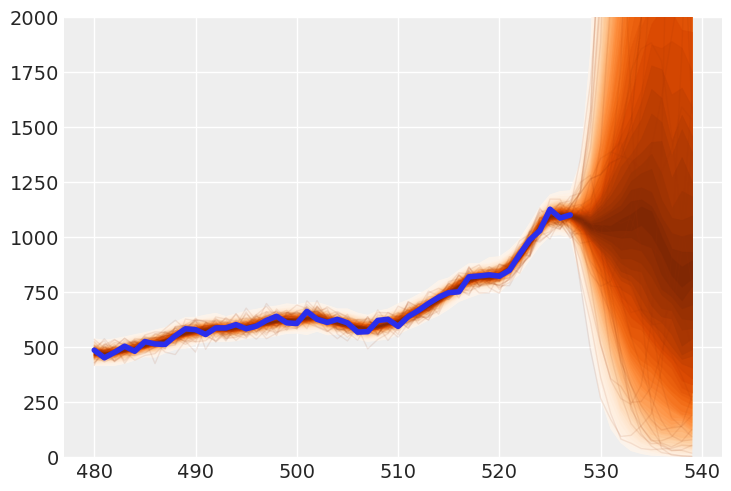

In [36]:
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, pred_samples['y_pred_10'][:500,:], X_new[:,0], palette='Oranges')
plt.plot(np.arange(n*10, n*11),y[:,10])
plt.ylim(0, 2000);

There is too much uncertainty, the model does not really know how to handle such disparity between states, gender and legal counts. This is where our time-varying and time-invariant enter to help removing those effects.

### 1.3.2 Multi-output GP prior

#### 1.3.2.1 Mean functions

#### 1.3.2.2 Cov functions

#### 1.3.2.3 Performance

##### 1.3.2.3.2 Sparse approximations

https://docs.pymc.io/notebooks/GP-SparseApprox.html


### 1.3.3 Different size inputs


### 1.3.4 Fixed and random effects

### 1.3.1 Different groups with individual base rates multiplied by a latent process

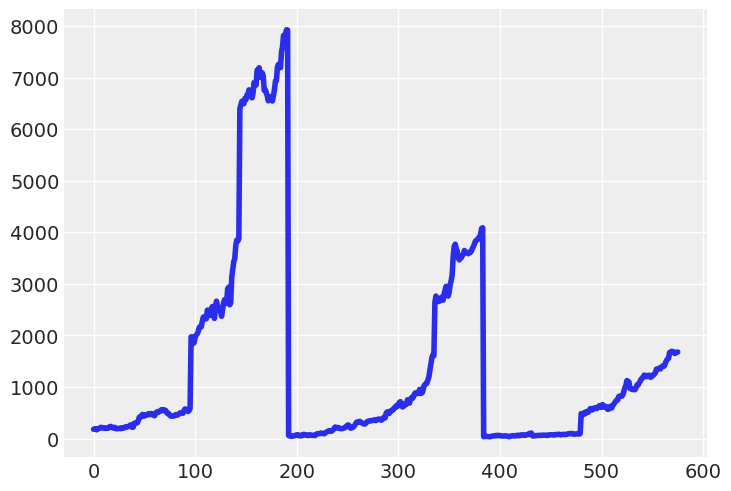

In [84]:
y_ = y

n=y_.shape[0]
s=y_.shape[1]
h = np.zeros((n*s,))
for s_ in range(s): 
    for n_ in range(n):
        h[(n)*s_+n_] = s_

h = h[:,None]
t = np.arange(n*s)[:,None]
X = np.hstack((t, h))

y_ = y_.flatten('F')
plt.plot(y_);

In [82]:
state_idx = pd.get_dummies(
        [i[0] for i in y]
    ).values.argmax(1)

gender_idx = pd.get_dummies(
        [i[1] for i in y]
    ).values.argmax(1)

legal_idx = pd.get_dummies(
        [i[2] for i in y]
    ).values.argmax(1)

state = np.unique(state_idx).shape[0]
gender = np.unique(gender_idx).shape[0]
legal = np.unique(legal_idx).shape[0]

n_series = y.shape[1]

In [96]:
import theano.tensor as T

n=y.shape[1]
with pm.Model() as model:
    
    # Hyper-parameter priors
    l_t = pm.Gamma('l_t', alpha=4, beta=1, shape=2)
    l_p = pm.Gamma('l_p', alpha=4, beta=1, shape=2)
    l_med = pm.Gamma('l_med', alpha=4, beta=1, shape=2)

    η_trend = pm.HalfNormal('η_trend', 1)
    η_per = pm.HalfNormal('η_per',1)
    η_med = pm.HalfNormal('η_med', 1)
    period = pm.HalfNormal('period', 1)
    
    
    l = pm.Gamma('l', alpha=4, beta=1, shape=2)
    η = pm.HalfNormal('η', 1)
    
    # Cov func
    cov_func = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l_t)
                + η**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=l)
                + η_per**2 * pm.gp.cov.Periodic(2, period=period, ls=l_p) 
                + η_med**2 * pm.gp.cov.RatQuad(2, ls=l_med, alpha=1))

    # Latent Gaussian Process
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior('f', X=X, reparameterize=True)
    print(f.tag.test_value.shape)
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    hy_a0_mu = pm.Normal('hy_a0_mu', mu=y[0,:].mean(), sd=50)
    hy_a1 = pm.Normal('hy_a1', mu=0.0, sd=100)
    hy_a2 = pm.Normal('hy_a2', mu=0.0, sd=100)
    hy_a3 = pm.Normal('hy_a3', mu=0.0, sd=100)
    
    a0 = pm.Normal('a0', mu=hy_a0_mu, sd=100, shape=(1,n_series))      
    a1 = pm.Normal('a1', mu=hy_a1, sd=100, shape=(1,state))
    a2 = pm.Normal('a2', mu=hy_a2, sd=100, shape=(1,gender))
    a3 = pm.Normal('a3', mu=hy_a3, sd=100, shape=(1,legal))
    mu = pm.math.exp(a0 + 
          a1[:,state_idx] + a2[:,gender_idx] + a3[:,legal_idx] + 
          f.reshape(n,1))
    
    a_var = pm.Exponential('a_var', lam=0.1)
    random_effect = pm.Normal('random_effect', mu=0.0, sd=a_var, shape=(1,n))
    
    y_pred = pm.Poisson('y_pred', mu=T.dot(mu, pm.math.exp(random_effect)), observed=y)

(576,)


ValueError: Input dimension mis-match. (input[0].shape[1] = 12, input[1].shape[1] = 48)

In [442]:
with model:
    trace = pm.sample(draws=1000, chains=2, cores=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [random_effect, individual_var, intercept, f_rotated_, ℓ_trend, η_trend, α, ℓ_med, η_med, ℓ_psmooth , period, η_per]
INFO:pymc3:NUTS: [random_effect, individual_var, intercept, f_rotated_, ℓ_trend, η_trend, α, ℓ_med, η_med, ℓ_psmooth , period, η_per]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1733 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1733 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8875917044758658, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1037 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1037 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2669770618935053, but should be close to 0.8. Try to increase the number of tuning steps.
T

In [443]:
az.summary(trace, var_names=['~f', '~base_lam', '~f_rotated_'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period,4.019,0.028,3.973,4.048,0.017,0.014,3.0,3.0,3.0,31.0,1.82
intercept,7.569,2.241,4.336,9.757,1.543,1.314,2.0,2.0,3.0,11.0,1.93
"random_effect[0,0]",-1.186,0.323,-1.534,-0.864,0.227,0.192,2.0,2.0,3.0,11.0,2.30
"random_effect[0,1]",-0.035,0.727,-0.786,0.702,0.512,0.433,2.0,2.0,2.0,14.0,2.51
"random_effect[0,2]",1.619,0.729,0.865,2.349,0.514,0.435,2.0,2.0,3.0,11.0,2.03
"random_effect[0,3]",2.606,0.729,1.853,3.337,0.513,0.434,2.0,2.0,2.0,11.0,2.39
"random_effect[0,4]",-1.696,0.731,-2.451,-0.963,0.514,0.435,2.0,2.0,3.0,11.0,2.05
"random_effect[0,5]",-0.542,0.733,-1.300,0.190,0.516,0.436,2.0,2.0,3.0,12.0,2.07
"random_effect[0,6]",0.489,0.729,-0.265,1.220,0.514,0.435,2.0,2.0,2.0,11.0,2.55
"random_effect[0,7]",1.883,0.729,1.129,2.614,0.514,0.435,2.0,2.0,3.0,11.0,2.20


In [390]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(18,15), sharex=True)
n_samp = 2000
n=48
s=2


for i in range(2):
    # GP

    gp_t = np.exp(trace['f'].T)
    CI_gp_t = np.percentile(gp_t,axis=1,q=[2.5,50, 97.5])
    ax[0,i].plot(CI_gp_t[1], label="mean")
    ax[0,i].fill_between(np.arange(n),CI_gp_t[0],
                     CI_gp_t[2],
                     alpha=0.25,label='95% credible interval')
    ax[0,i].set_title("GP")
    ax[0,i].legend()

    # Level

    l_t = np.exp(trace['intercept'].reshape(1, n_samp))
    CI_l_t = np.tile(np.percentile(l_t,axis=1,q=[2.5,50, 97.5]), (1,n))
    ax[1,i].plot(CI_l_t[1], label="mean")
    #ax[1,i].fill_between(np.arange(n),CI_l_t[0],
    #                 CI_l_t[2],
    #                 alpha=0.25,label='95% credible interval')
    ax[1,i].set_title("Level")
    ax[1,i].legend()


    # Random effects
    CI_re = np.tile(np.percentile(np.exp(trace['random_effect']),axis=0,q=[2.5,50, 97.5])[:,:, i], (1,n))
    ax[2,i].plot(CI_re[1], label="mean")
    #ax[2,i].fill_between(np.arange(y.shape[0]),CI_re[0],
    #                 CI_re[2],
    #                 alpha=0.25,label='95% credible interval')
    ax[2,i].legend()
    ax[2,i].set_title("Random effects")

    # GP + Level + Random effects
    CI_y_pred = np.percentile(ppc['y_pred'][:,:,i], axis=0,q=[2.5,50,97.5])

    ax[3,i].plot(CI_y_pred[1], label="mean")
    ax[3,i].fill_between(np.arange(y.shape[0]),CI_y_pred[0],
                     CI_y_pred[2],
                     alpha=0.25,label='95% credible interval')
    ax[3,i].scatter(np.arange(y.shape[0]),y[:,i], color="forestgreen")
    ax[3,i].set_title("GP + Level + Random effects");

In [393]:
ppc['y_pred'].shape

(2000, 48, 12)

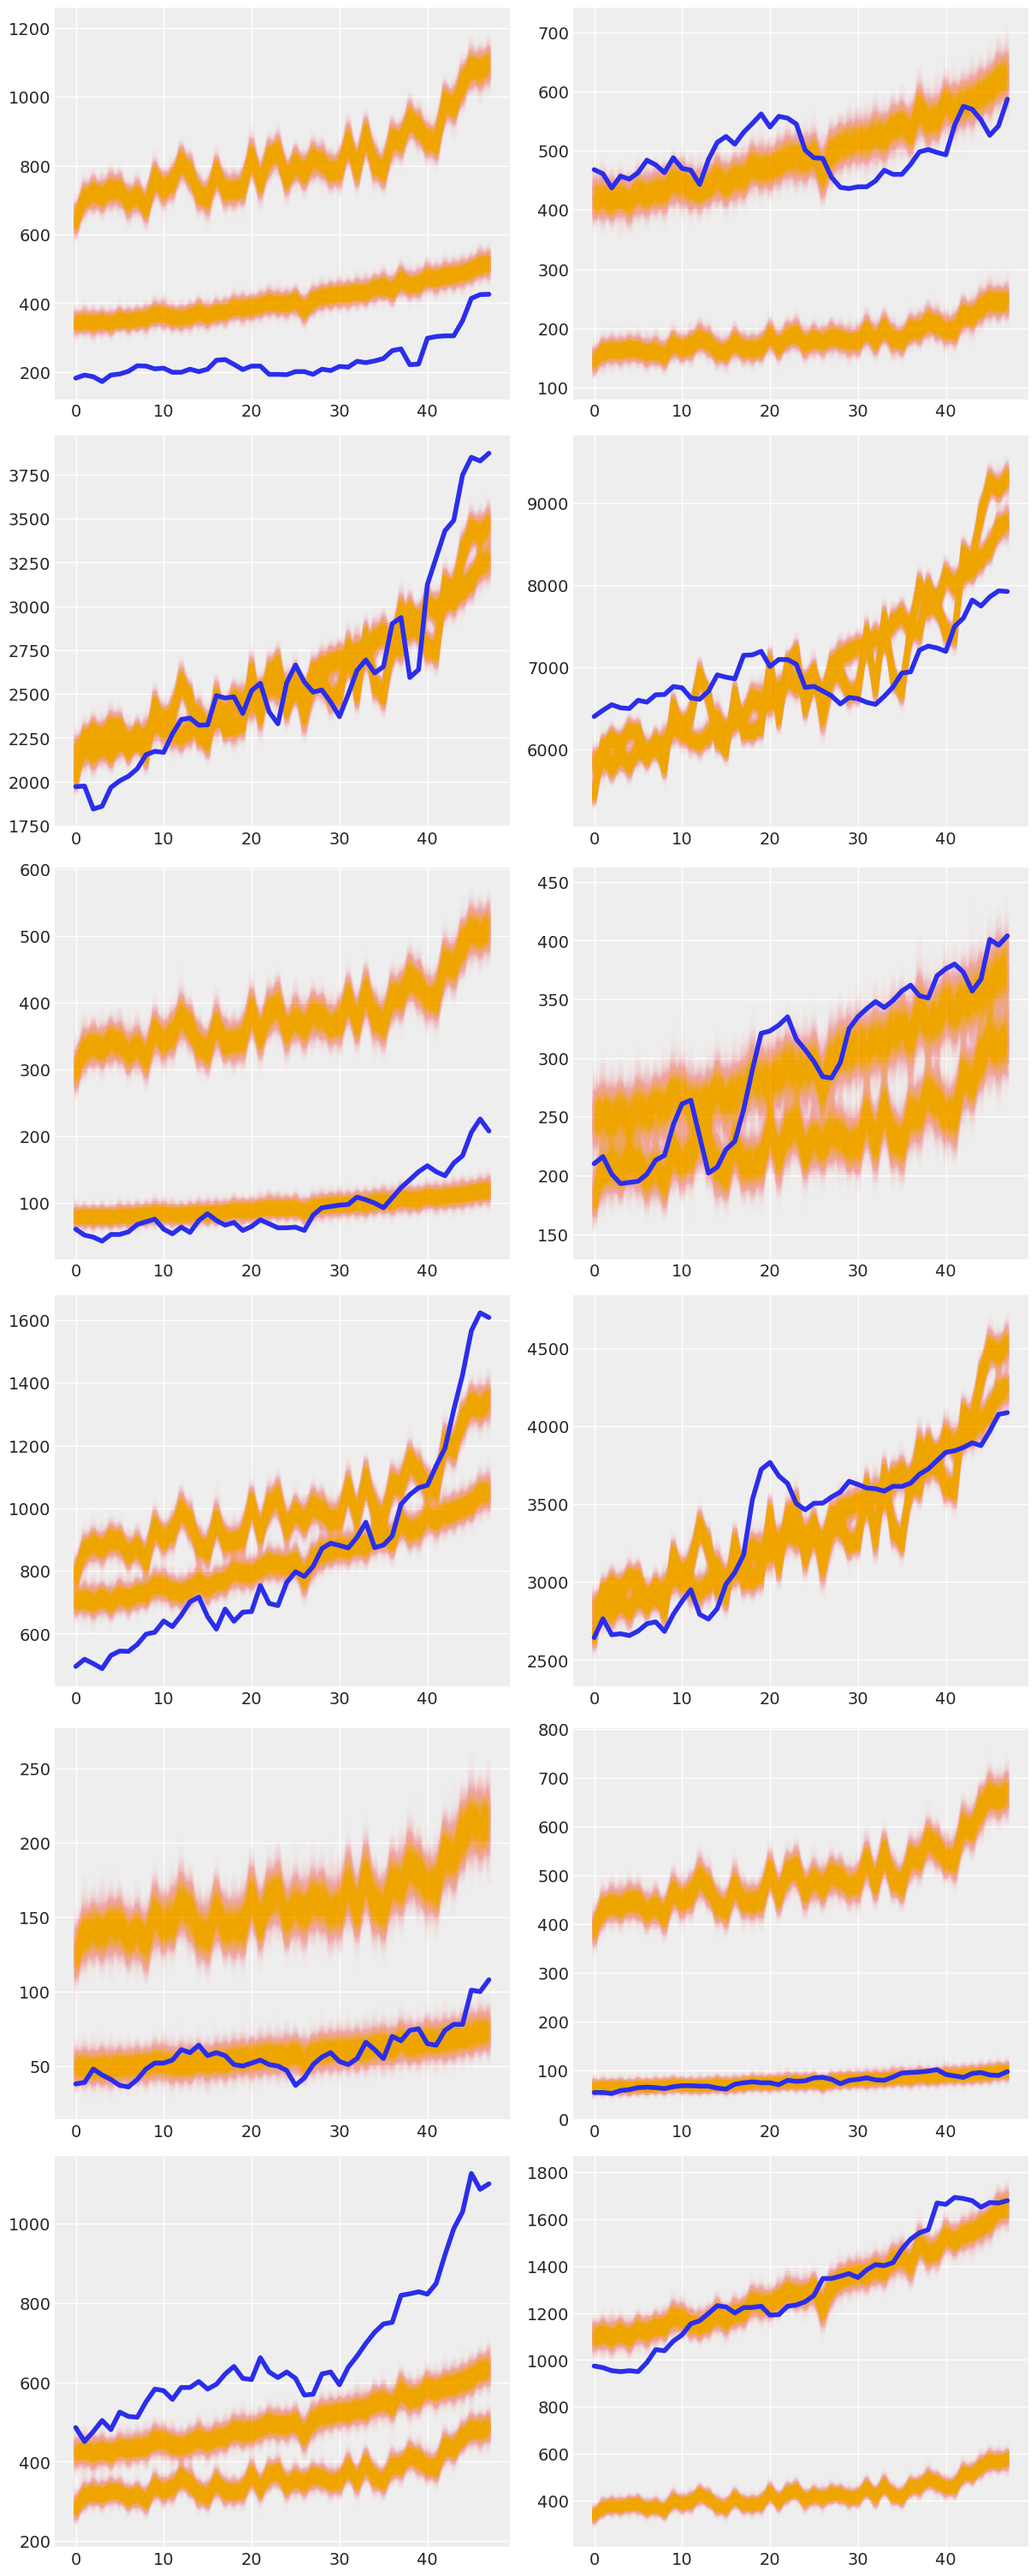

In [399]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)
for i in range(12):
    ax[i].plot(X, ppc['y_pred'][:,:,i].T, alpha=0.003, color='orange')
    ax[i].plot(y[:,i]);